In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_columns", None)

In [2]:
# 1. Load Datasets

df_train = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/raw/train.csv", index_col=0)
df_dev = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/raw/dev.csv", index_col=0)
df_test = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/raw/test.csv", index_col=0)
metro_data = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/raw/usmetros.csv")


In [3]:
df_train.columns

Index(['date', 'median_sale_price', 'median_list_price', 'median_ppsf',
       'median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings',
       'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list',
       'off_market_in_two_weeks', 'city', 'zipcode', 'year', 'bank', 'bus',
       'hospital', 'mall', 'park', 'restaurant', 'school', 'station',
       'supermarket', 'Total Population', 'Median Age', 'Per Capita Income',
       'Total Families Below Poverty', 'Total Housing Units', 'Median Rent',
       'Median Home Value', 'Total Labor Force', 'Unemployed Population',
       'Total School Age Population', 'Total School Enrollment',
       'Median Commute Time', 'price', 'city_full'],
      dtype='object')

### Map Cities to Lat/Long Coordinates instead of nominal/OH encoding 

This approach ensures one city is not preferred over the another due to nominal encoding drawbacks. It is also faster compared to OH encoding, and it gives the model a sense of geography. 

In [3]:
print(df_train.city_full.unique())
print(df_train.city_full.nunique())

['Atlanta-Sandy Springs-Alpharetta' 'Pittsburgh' 'Boston-Cambridge-Newton'
 'Tampa-St. Petersburg-Clearwater' 'Baltimore-Columbia-Towson'
 'Portland-Vancouver-Hillsboro' 'Philadelphia-Camden-Wilmington'
 'New York-Newark-Jersey City' 'Chicago-Naperville-Elgin'
 'Orlando-Kissimmee-Sanford' 'Seattle-Tacoma-Bellevue'
 'San Francisco-Oakland-Berkeley' 'San Diego-Chula Vista-Carlsbad'
 'Austin-Round Rock-Georgetown' 'St. Louis' 'Sacramento-Roseville-Folsom'
 'Phoenix-Mesa-Chandler' 'Riverside-San Bernardino-Ontario'
 'San Antonio-New Braunfels' 'Detroit-Warren-Dearborn' 'Cincinnati'
 'Houston-The Woodlands-Sugar Land' 'Charlotte-Concord-Gastonia'
 'Denver-Aurora-Lakewood' 'Los Angeles-Long Beach-Anaheim' 'DC_Metro'
 'Dallas-Fort Worth-Arlington' 'Minneapolis-St. Paul-Bloomington'
 'Las Vegas-Henderson-Paradise' 'Miami-Fort Lauderdale-Pompano Beach']
30


In [4]:
metro_cities = list(metro_data.metro_full.unique())
metro_cities = [city.split(', ')[0] for city in metro_cities]

In [5]:
metro_cities

['New York-Newark-Jersey City',
 'Los Angeles-Long Beach-Anaheim',
 'Chicago-Naperville-Elgin',
 'Dallas-Fort Worth-Arlington',
 'Houston-Pasadena-The Woodlands',
 'Atlanta-Sandy Springs-Roswell',
 'Washington-Arlington-Alexandria',
 'Philadelphia-Camden-Wilmington',
 'Miami-Fort Lauderdale-West Palm Beach',
 'Phoenix-Mesa-Chandler',
 'Boston-Cambridge-Newton',
 'Riverside-San Bernardino-Ontario',
 'San Francisco-Oakland-Fremont',
 'Detroit-Warren-Dearborn',
 'Seattle-Tacoma-Bellevue',
 'Minneapolis-St. Paul-Bloomington',
 'Tampa-St. Petersburg-Clearwater',
 'San Diego-Chula Vista-Carlsbad',
 'Denver-Aurora-Centennial',
 'Baltimore-Columbia-Towson',
 'Orlando-Kissimmee-Sanford',
 'Charlotte-Concord-Gastonia',
 'St. Louis',
 'San Antonio-New Braunfels',
 'Portland-Vancouver-Hillsboro',
 'Austin-Round Rock-San Marcos',
 'Pittsburgh',
 'Sacramento-Roseville-Folsom',
 'Las Vegas-Henderson-North Las Vegas',
 'Cincinnati',
 'Kansas City',
 'Columbus',
 'Cleveland',
 'Indianapolis-Carmel-Gree

In [6]:
count = 0
for city in list(df_train.city_full.unique()):
    if city not in metro_cities:
        count+=1
        print(city)
print(count)

Atlanta-Sandy Springs-Alpharetta
San Francisco-Oakland-Berkeley
Austin-Round Rock-Georgetown
Houston-The Woodlands-Sugar Land
Denver-Aurora-Lakewood
DC_Metro
Las Vegas-Henderson-Paradise
Miami-Fort Lauderdale-Pompano Beach
8


In [7]:
count = 0
for city in list(df_dev.city_full.unique()):
    if city not in metro_cities:
        count+=1
        print(city)
print(count)

Atlanta-Sandy Springs-Alpharetta
Las Vegas-Henderson-Paradise
San Francisco-Oakland-Berkeley
Austin-Round Rock-Georgetown
DC_Metro
Denver-Aurora-Lakewood
Miami-Fort Lauderdale-Pompano Beach
Houston-The Woodlands-Sugar Land
8


In [8]:
city_map_for_correction = {
    'Atlanta-Sandy Springs-Alpharetta': 'Atlanta-Sandy Springs-Roswell',
    'San Francisco-Oakland-Berkeley':'San Francisco-Oakland-Fremont',
    'Austin-Round Rock-Georgetown': 'Austin-Round Rock-San Marcos',
    'Houston-The Woodlands-Sugar Land': 'Houston-Pasadena-The Woodlands',
    'Denver-Aurora-Lakewood':  'Denver-Aurora-Centennial',
    'DC_Metro': 'Washington-Arlington-Alexandria',
    'Las Vegas-Henderson-Paradise': 'Las Vegas-Henderson-North Las Vegas',
    'Miami-Fort Lauderdale-Pompano Beach': 'Miami-Fort Lauderdale-West Palm Beach'
}

In [9]:
metro_data['metro_full'] = metro_data['metro_full'].apply(lambda x: x.split(', ')[0])

In [10]:
def clean_and_merge(df: pd.DataFrame) -> pd.DataFrame:
    """Apply city name correction, merge lat/long from metro data and drop duplicate columns"""
    df['city_full'] = df['city_full'].replace(city_map_for_correction)

    df = df.merge(
        metro_data[['metro_full', 'lat', 'lng']],
        how='left',
        left_on='city_full',
        right_on='metro_full'
        )
    
    df.drop(columns='metro_full', inplace=True)

    # Log any missing cities
    missing = df[df.lat.isnull()]['city_full'].unique()
    if len(missing) > 0:
        print(f"Missing lat/lng for {missing}")
    else:
        print("All cities matched with metros dataset")

    return df


In [11]:
# Apply cleaning
df_train = clean_and_merge(df_train)
df_dev = clean_and_merge(df_dev)
df_test = clean_and_merge(df_test)


All cities matched with metros dataset
All cities matched with metros dataset
All cities matched with metros dataset


In [66]:
df_train.drop_duplicates()

,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,year,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng
0,2012-03-31,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,0.943662,0.142857,0.043478,ATL,30002,2012,12.0,2.0,4.0,1.0,60.0,45.0,57.0,4.0,7.0,5811.0,36.3,33052.0,5811.0,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,Atlanta-Sandy Springs-Roswell,33.7338,-84.3922
1,2012-03-31,200000.0,7500.0,104.931794,79.265873,1.0,1.0,1.0,2.0,290.0,0.909091,0.000000,0.000000,PGH,15469,2012,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2441.0,41.8,20241.0,2385.0,1108.0,641.0,94600.0,1171.0,52.0,2376.0,2376.0,1018.0,105863.681174,Pittsburgh,40.4744,-79.8632
2,2012-03-31,75750.0,92400.0,165.898618,63.412698,2.0,2.0,4.0,13.0,193.0,0.986815,0.000000,0.000000,PGH,15468,2012,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,2171.0,47.8,18740.0,2094.0,1252.0,627.0,62800.0,894.0,30.0,2106.0,2106.0,807.0,60152.096646,Pittsburgh,40.4744,-79.8632
3,2012-03-31,79900.0,79900.0,0.696203,0.000000,1.0,1.0,1.0,1.0,46.0,1.000000,0.000000,0.000000,PGH,15466,2012,1.0,0.0,0.0,0.0,0.0,2.0,8.0,0.0,0.0,425.0,46.8,23067.0,425.0,208.0,534.0,66200.0,216.0,7.0,414.0,414.0,208.0,44042.242632,Pittsburgh,40.4744,-79.8632
4,2012-03-31,196000.0,198000.0,122.807018,124.060150,1.0,1.0,1.0,1.0,49.0,0.989899,0.000000,0.000000,PGH,15464,2012,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1515.0,45.1,18623.0,1508.0,692.0,484.0,79300.0,711.0,61.0,1489.0,1489.0,641.0,126572.277873,Pittsburgh,40.4744,-79.8632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585239,2019-12-31,200000.0,174950.0,147.252833,146.268997,141.0,124.0,96.0,102.0,45.0,0.962153,0.078014,0.209677,CHI,60074,2019,22.0,0.0,0.0,7.0,101.0,54.0,43.0,3.0,15.0,39478.0,35.0,32836.0,39391.0,15272.0,1128.0,240700.0,22996.0,992.0,37686.0,37686.0,20706.0,206419.352255,Chicago-Naperville-Elgin,41.6675,-87.9597
585240,2019-12-31,292500.0,439900.0,105.120848,128.498562,2.0,3.0,4.0,5.0,378.5,0.946140,0.000000,0.000000,DC,25446,2019,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,1205.0,52.4,48998.0,1205.0,667.0,1442.0,339000.0,683.0,0.0,1161.0,1161.0,651.0,281308.244252,Washington-Arlington-Alexandria,38.8446,-77.5092
585241,2019-12-31,367250.0,507249.5,170.350292,141.217953,6.0,5.0,4.0,2.0,8.0,0.981592,0.166667,0.600000,DC,20860,2019,13.0,0.0,1.0,0.0,43.0,24.0,24.0,0.0,5.0,2805.0,40.3,51265.0,2708.0,882.0,1094.0,758300.0,1219.0,99.0,2759.0,2759.0,1005.0,629087.253155,Washington-Arlington-Alexandria,38.8446,-77.5092
585242,2019-12-31,129000.0,124999.0,116.340593,112.565445,118.0,121.0,133.0,65.0,15.0,0.977204,0.245763,0.371901,DET,48186,2019,11.0,0.0,1.0,1.0,52.0,26.0,56.0,0.0,10.0,34255.0,39.2,25285.0,34134.0,14540.0,922.0,103000.0,17065.0,1162.0,33048.0,33048.0,14995.0,131588.551302,Detroit-Warren-Dearborn,42.7196,-83.2329


In [15]:
assert df_train["Total School Age Population"].all() == df_train["Total School Enrollment"].all()
assert df_dev["Total School Age Population"].all() == df_dev["Total School Enrollment"].all()
assert df_test["Total School Age Population"].all() == df_test["Total School Enrollment"].all()

### Cleaning Duplicates

In [12]:
columns_excluding_time_information = df_train.columns.difference(['date', 'year'])

# Want to check if there are any rows that have exact same value of all columns: This will imply that same data was fetched late as this is already an aggregated data.
print(df_train.duplicated(subset=columns_excluding_time_information).sum())
print(df_dev.duplicated(subset=columns_excluding_time_information).sum())
print(df_test.duplicated(subset=columns_excluding_time_information).sum())



6321
726
343


In [13]:
df_train = df_train[~df_train.duplicated(subset=columns_excluding_time_information)]
df_dev = df_dev[~df_dev.duplicated(subset=columns_excluding_time_information)]
df_test = df_test[~df_test.duplicated(subset=columns_excluding_time_information)]

### Cleaning Outliers

In [14]:
df_train.describe()

,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,zipcode,year,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,lat,lng
count,5.789230e+05,5.789230e+05,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,5.789230e+05,578923.000000,578923.000000,578923.000000,578923.000000,578923.000000,5.789230e+05,578923.000000,578923.000000
mean,3.393784e+05,3.729765e+05,195.173449,203.635641,76.579813,82.561572,95.567882,89.631517,69.794635,0.971182,0.213463,0.239441,48762.154238,2015.586803,10.178272,0.530148,4.060733,1.166824,44.856696,48.353190,49.890459,5.787490,7.992880,21636.011288,36.348807,32488.005499,21288.829587,8647.519325,1065.564330,2.859811e+05,11329.634494,928.594466,20816.968011,20816.968011,9672.938085,3.401244e+05,37.825945,-90.908588
std,3.302849e+05,2.314906e+06,843.860029,308.333461,74.879805,84.857639,93.174568,95.888200,85.896510,0.058934,0.164936,0.204030,32393.368870,2.254516,25.313986,1.330809,8.567054,2.613684,74.058513,148.263718,63.976747,16.851923,15.167786,19435.387470,12.282992,19589.859974,19196.432375,7442.322703,488.420685,2.359187e+05,10191.339637,1039.773835,18636.450725,18636.450725,8722.747362,3.016669e+05,5.002350,16.742084
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1431.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.046432e+04,26.157300,-122.478300
25%,1.600000e+05,1.720000e+05,97.119997,103.411975,19.000000,18.000000,25.000000,26.000000,32.000000,0.960069,0.102564,0.035242,19050.000000,2014.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,7.000000,0.000000,0.000000,4778.000000,33.700000,21936.000000,4629.000000,2019.000000,817.000000,1.322000e+05,2444.000000,154.000000,4630.000000,4630.000000,2063.000000,1.663567e+05,34.221500,-98.602300
50%,2.590000e+05,2.750000e+05,141.213235,149.137737,56.000000,58.000000,70.000000,61.000000,53.000000,0.976516,0.186335,0.227273,48033.000000,2016.000000,3.000000,0.000000,1.000000,0.000000,21.000000,9.000000,28.000000,0.000000,3.000000,17782.000000,38.200000,29701.000000,17441.000000,7425.000000,1043.000000,2.286000e+05,9252.000000,611.000000,17197.000000,17197.000000,7900.000000,2.631885e+05,39.081100,-84.392200
75%,4.105000e+05,4.390000e+05,223.152602,234.407326,111.000000,121.000000,137.000000,120.000000,85.500000,0.990150,0.293103,0.380165,78676.000000,2018.000000,10.000000,0.000000,4.000000,1.000000,57.000000,36.000000,68.000000,4.000000,10.000000,33077.000000,42.800000,40662.000000,32555.000000,13420.000000,1333.000000,3.777000e+05,17443.000000,1338.000000,31850.000000,31850.000000,14907.000000,4.154993e+05,40.722200,-76.580700
max,1.550000e+07,1.000000e+09,366700.000000,143015.398551,885.000000,982.000000,1047.000000,1941.000000,7777.000000,1.906250,1.000000,1.000000,98686.000000,2019.000000,416.000000,26.000000,96.000000,45.000000,926.000000,2803.000000,560.000000,192.000000,259.000000,122814.000000,87.200000,465868.000000,122343.000000,48734.000000,3501.000000,2.000001e+06,66704.000000,9735.000000,117632.000000,117632.000000,59316.000000,6.342460e+06,47.557400,-71.100700


In [15]:
df_train["median_list_price"].describe() # We have outliers here

count    5.789230e+05
mean     3.729765e+05
std      2.314906e+06
min      0.000000e+00
25%      1.720000e+05
50%      2.750000e+05
75%      4.390000e+05
max      1.000000e+09
Name: median_list_price, dtype: float64

In [16]:
df_train.sort_values(by='median_list_price', ascending=False)

,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,year,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng
283729,2015-12-31,439444.0,999999999.0,217.479377,231.798505,254.0,255.0,536.0,136.0,53.0,0.976354,0.137795,0.109804,DC,20878,2015,9.0,0.0,4.0,1.0,110.0,59.0,50.0,2.0,11.0,63855.0,38.1,52955.0,63757.0,23514.0,1677.0,535500.0,36595.0,1960.0,61237.0,61237.0,32125.0,515206.049773,Washington-Arlington-Alexandria,38.8446,-77.5092
271684,2015-10-31,439000.0,999999999.0,218.867925,236.391156,243.0,269.0,671.0,259.0,46.0,0.980975,0.160494,0.130112,DC,20878,2015,9.0,0.0,4.0,1.0,110.0,59.0,50.0,2.0,11.0,63855.0,38.1,52955.0,63757.0,23514.0,1677.0,535500.0,36595.0,1960.0,61237.0,61237.0,32125.0,514388.985999,Washington-Arlington-Alexandria,38.8446,-77.5092
275824,2015-11-30,425000.0,999999999.0,220.055710,236.634569,241.0,284.0,616.0,196.0,47.0,0.979123,0.132780,0.133803,DC,20878,2015,9.0,0.0,4.0,1.0,110.0,59.0,50.0,2.0,11.0,63855.0,38.1,52955.0,63757.0,23514.0,1677.0,535500.0,36595.0,1960.0,61237.0,61237.0,32125.0,514884.401131,Washington-Arlington-Alexandria,38.8446,-77.5092
323492,2016-06-30,415000.0,50449949.5,257.508343,4156.568441,2.0,2.0,2.0,2.0,324.5,1.000447,0.500000,0.000000,DC,20838,2016,0.0,0.0,0.0,0.0,11.0,1.0,4.0,2.0,0.0,247.0,49.6,61165.0,243.0,93.0,1507.0,607100.0,135.0,0.0,239.0,239.0,122.0,673997.281067,Washington-Arlington-Alexandria,38.8446,-77.5092
312332,2016-05-31,270000.0,50449949.5,232.758621,4156.568441,1.0,1.0,2.0,2.0,264.0,1.000000,0.000000,0.000000,DC,20838,2016,0.0,0.0,0.0,0.0,11.0,1.0,4.0,2.0,0.0,247.0,49.6,61165.0,243.0,93.0,1507.0,607100.0,135.0,0.0,239.0,239.0,122.0,673997.281067,Washington-Arlington-Alexandria,38.8446,-77.5092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494222,2018-10-31,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,CIN,41045,2018,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,1809.0,36.8,21024.0,1806.0,720.0,781.0,113200.0,889.0,86.0,1753.0,1753.0,799.0,97958.168637,Cincinnati,39.0811,-84.4646
510863,2019-01-31,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,DEN,80448,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,38.2,39447.0,55.0,213.0,1271.0,337300.0,38.0,0.0,55.0,55.0,38.0,406732.392329,Denver-Aurora-Centennial,39.4337,-104.8944
553303,2019-07-31,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,SEA,98050,2019,0.0,0.0,0.0,0.0,8.0,4.0,4.0,0.0,1.0,552.0,45.0,73187.0,552.0,205.0,1332.0,662500.0,336.0,0.0,552.0,552.0,336.0,871528.137237,Seattle-Tacoma-Bellevue,47.5574,-121.8506
337482,2016-09-30,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,PHL,19437,2016,5.0,0.0,0.0,0.0,18.0,21.0,24.0,5.0,7.0,638.0,65.5,121454.0,638.0,303.0,1066.0,836400.0,206.0,18.0,638.0,638.0,172.0,631643.135847,Philadelphia-Camden-Wilmington,39.9056,-75.3020


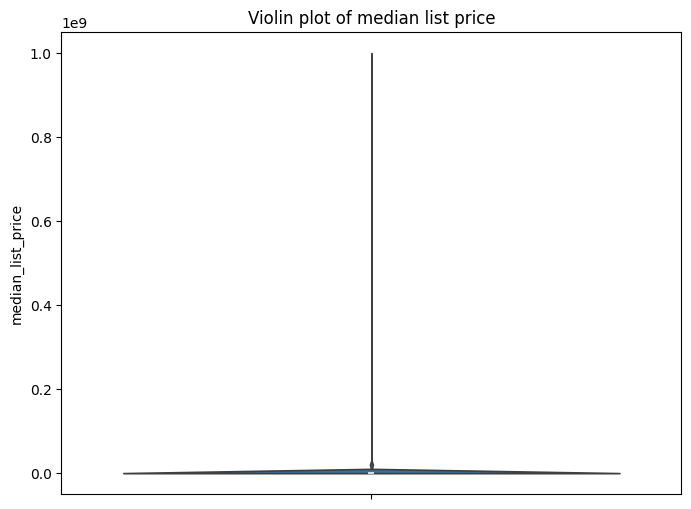

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sns.violinplot(
    y=df_train['median_list_price'],
    inner='box'   # shows the boxplot inside the violin
)

plt.title("Violin plot of median list price")
plt.ylabel("median_list_price")

plt.show()

In [18]:
top_1_percent = df_train.nlargest(int(0.01*len(df_train)), columns=['median_list_price'])
top_1_percent.groupby("median_list_price").size().sort_index(ascending=False)

median_list_price
999999999.0     3
50449949.5      3
27800000.0      1
19990000.0     38
15849000.0      1
               ..
1743500.0       1
1742000.0       1
1740000.0       4
1739000.0       1
1738000.0       2
Length: 1601, dtype: int64

In [19]:
# We can remove the entries where list price is more than 20 million dollars

df_train = df_train[df_train.median_list_price <= 20000000].copy()

df_dev = df_dev[df_dev.median_list_price <= 20000000].copy()

df_test = df_test[df_test.median_list_price <= 20000000].copy()

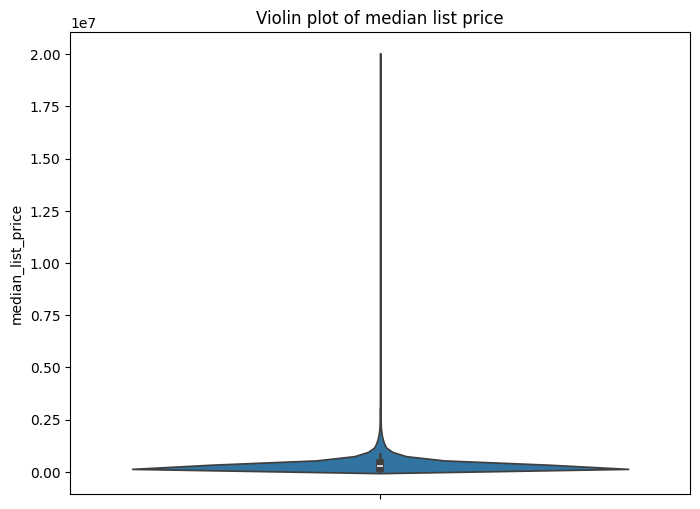

In [20]:
plt.figure(figsize=(8, 6))

sns.violinplot(
    data=df_train,
    y="median_list_price",
    inner="box"
)

plt.title("Violin plot of median list price")
plt.ylabel("median_list_price")

plt.show()

In [19]:
# Saving the data
df_train.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/cleaning_train.csv")
df_dev.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/cleaning_dev.csv")
df_test.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/cleaning_test.csv")

### EDA

In [3]:
df_train = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/cleaning_train.csv", index_col=0)
df_dev = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/cleaning_dev.csv", index_col=0)

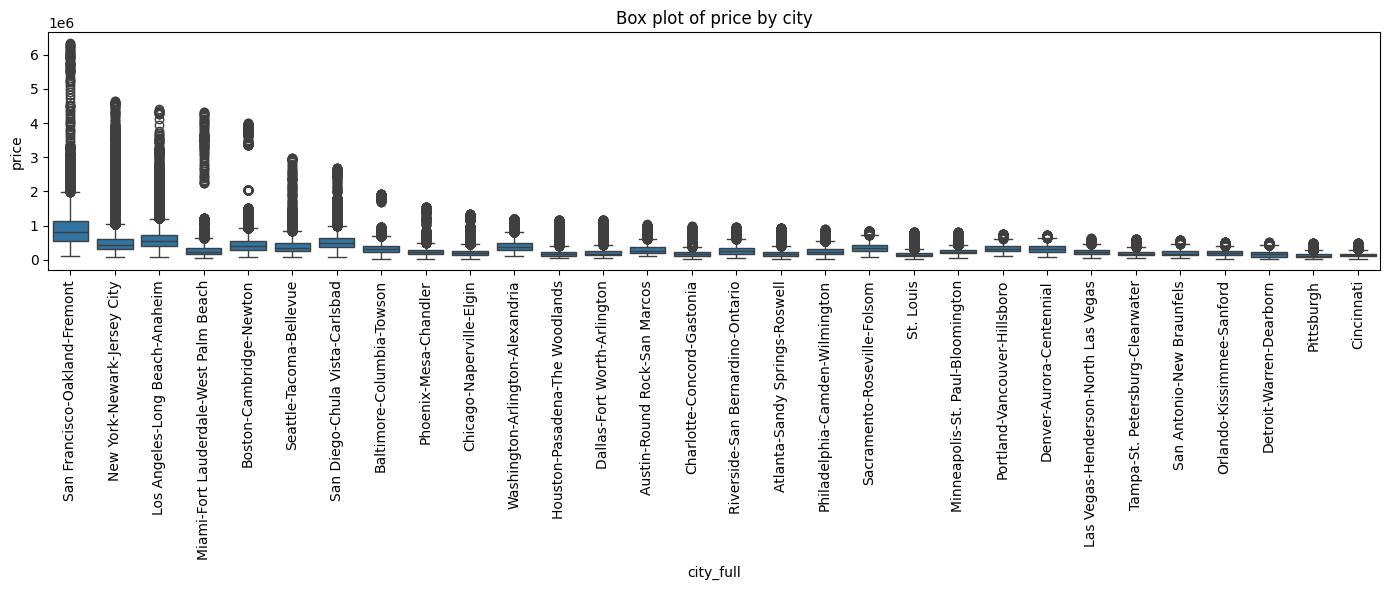

In [21]:
# House Price Exploration

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

sns.boxplot(
    data=df_train.sort_values(by="price", ascending=False),
    x="city_full",
    y="price"
)

plt.xticks(rotation=90)
plt.title("Box plot of price by city")
plt.xlabel("city_full")
plt.ylabel("price")

plt.tight_layout()
plt.show()


<Axes: xlabel='price', ylabel='Count'>

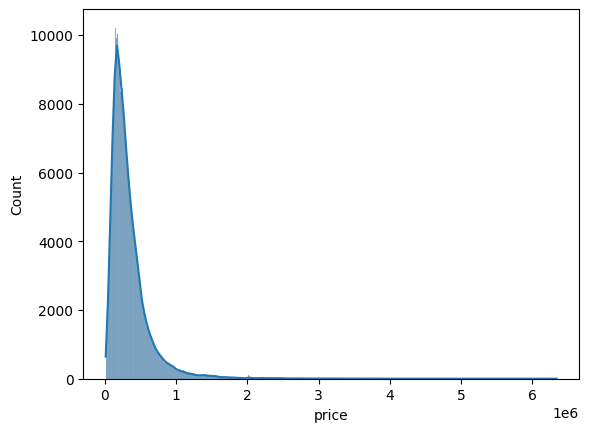

In [4]:
sns.histplot(df_train["price"], kde=True)

In [5]:
df_train.city_full.unique()

array(['Atlanta-Sandy Springs-Roswell', 'Pittsburgh',
       'Boston-Cambridge-Newton', 'Tampa-St. Petersburg-Clearwater',
       'Baltimore-Columbia-Towson', 'Portland-Vancouver-Hillsboro',
       'Philadelphia-Camden-Wilmington', 'New York-Newark-Jersey City',
       'Chicago-Naperville-Elgin', 'Orlando-Kissimmee-Sanford',
       'Seattle-Tacoma-Bellevue', 'San Francisco-Oakland-Fremont',
       'San Diego-Chula Vista-Carlsbad', 'Austin-Round Rock-San Marcos',
       'St. Louis', 'Sacramento-Roseville-Folsom',
       'Phoenix-Mesa-Chandler', 'Riverside-San Bernardino-Ontario',
       'San Antonio-New Braunfels', 'Detroit-Warren-Dearborn',
       'Cincinnati', 'Houston-Pasadena-The Woodlands',
       'Charlotte-Concord-Gastonia', 'Denver-Aurora-Centennial',
       'Los Angeles-Long Beach-Anaheim',
       'Washington-Arlington-Alexandria', 'Dallas-Fort Worth-Arlington',
       'Minneapolis-St. Paul-Bloomington',
       'Las Vegas-Henderson-North Las Vegas',
       'Miami-Fort Lauderdal

<Axes: xlabel='date', ylabel='price'>

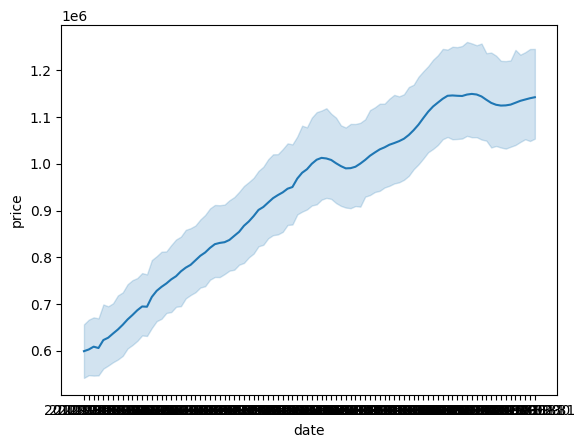

In [6]:
sns.lineplot(df_train[df_train.city_full=='San Francisco-Oakland-Fremont'], x='date', y='price')

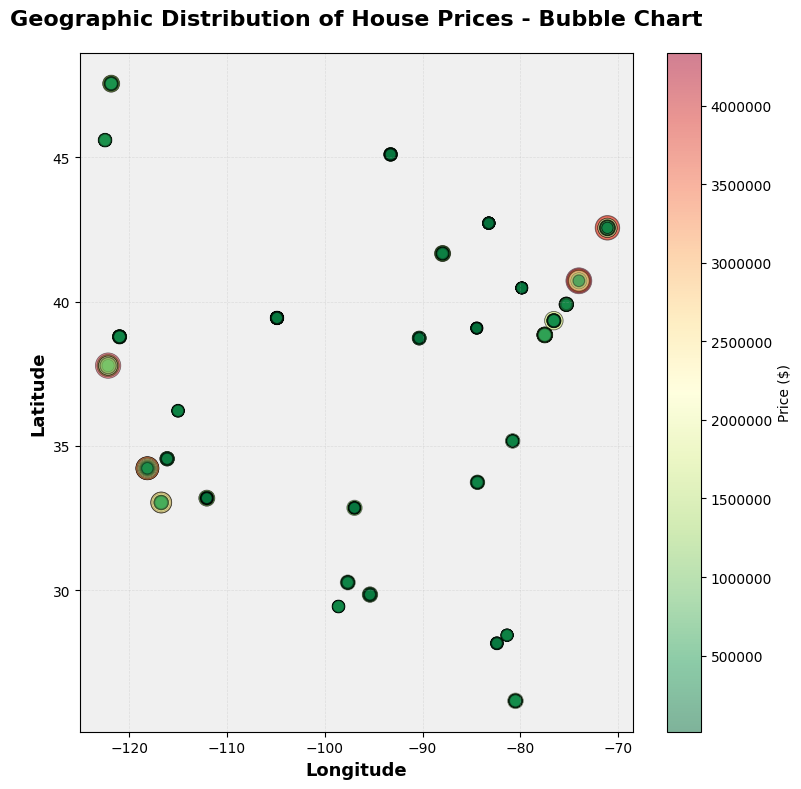

Plotted 10000 points out of 578916 total
Price range: $15,569 - $4,335,743


In [23]:
# Bubble map with price grading using matplotlib

df_sample = df_train.sample(10000)

# Create figure
fig, ax = plt.subplots(figsize=(8, 8))

# Normalize price for bubble sizes (making differences more visible)
price_normalized = (df_sample['price'] - df_sample['price'].min()) / (df_sample['price'].max() - df_sample['price'].min())
bubble_sizes = 50 + price_normalized * 300  # Bubble sizes between 50 and 350

# Create scatter plot with color grading
scatter = ax.scatter(
    df_sample['lng'],
    df_sample['lat'],
    c=df_sample['price'],
    s=bubble_sizes,  # Variable bubble size based on price
    cmap='RdYlGn_r',  # Red (high price) to Yellow to Green (low price)
    alpha=0.5,  # Transparency to see overlapping bubbles
    edgecolors='black',  # Black outline for better visibility
    linewidths=0.5
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Price ($)')
cbar.ax.ticklabel_format(style='plain', axis='y')

# Labels and title
ax.set_xlabel('Longitude', fontsize=13, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=13, fontweight='bold')
ax.set_title('Geographic Distribution of House Prices - Bubble Chart', fontsize=16, fontweight='bold', pad=20)

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Set background color
ax.set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()

print(f"Plotted {len(df_sample)} points out of {len(df_train)} total")
print(f"Price range: ${df_sample['price'].min():,.0f} - ${df_sample['price'].max():,.0f}")


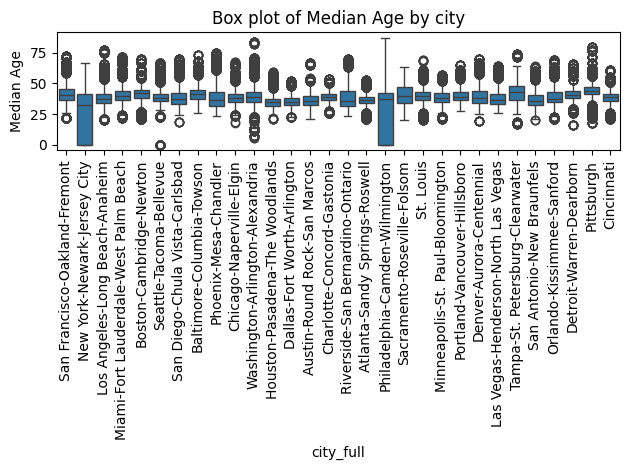

In [26]:
# Distribution of Age across each region


sns.boxplot(
    data=df_train.sort_values(by="price", ascending=False),
    x="city_full",
    y="Median Age"
)

plt.xticks(rotation=90)
plt.title("Box plot of Median Age by city")
plt.xlabel("city_full")
plt.ylabel("Median Age")

plt.tight_layout()
plt.show()

# Looking at the plot, we can hypothesise that age does not seem to be correlated with the prices which should be the case ideally.